In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, make_scorer, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor


%pip install numpy
import numpy as np

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sklearn
sklearn.__version__

'1.4.1.post1'

In [4]:
%pip install -U scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install lightgbm
import lightgbm as lgb
from lightgbm import LGBMRegressor

Note: you may need to restart the kernel to use updated packages.


# Определение стоимости автомобилей

## Подготовка данных

### Загрузка данных

In [6]:
data = pd.read_csv("https://code.s3.yandex.net/datasets/autos.csv")
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Аномальные значения

In [9]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'])
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['LastSeen'] = pd.to_datetime(data['LastSeen'])

In [10]:
data = data[data['RegistrationYear'] <= data['DateCreated'].dt.year]

In [11]:
data['Power'].describe()


count    339839.000000
mean        111.018918
std         186.976116
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1201c475880>,
 'caps': [<matplotlib.lines.Line2D at 0x1201c475f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x1201c475520>],
 'medians': [<matplotlib.lines.Line2D at 0x1201c488640>],
 'fliers': [<matplotlib.lines.Line2D at 0x1201c4889a0>],
 'means': []}

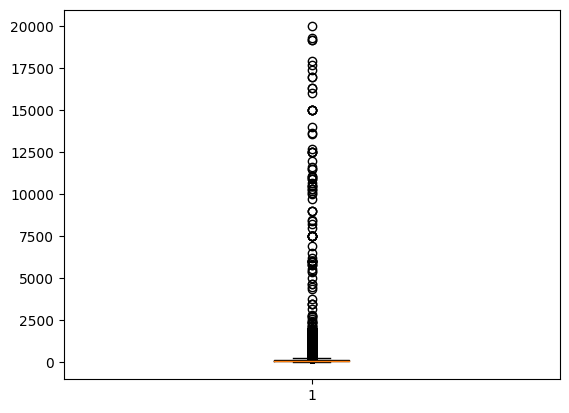

In [12]:
plt.boxplot(data['Power'])

In [13]:
data = data[(data['Power'] >= 70 ) & (data['Power'] <= 200 )]

Очень много выбросов в столбце мощности. Принял решение отсечь значения выше 200.

In [14]:
data['Price'].describe()

count    231280.000000
mean       4838.756767
std        4439.064354
min           0.000000
25%        1499.000000
50%        3350.000000
75%        6950.000000
max       20000.000000
Name: Price, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1201c4f5e80>,
 'caps': [<matplotlib.lines.Line2D at 0x1201c503580>,
 'boxes': [<matplotlib.lines.Line2D at 0x1201c4f5b20>],
 'medians': [<matplotlib.lines.Line2D at 0x1201c503c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x1201c503fa0>],
 'means': []}

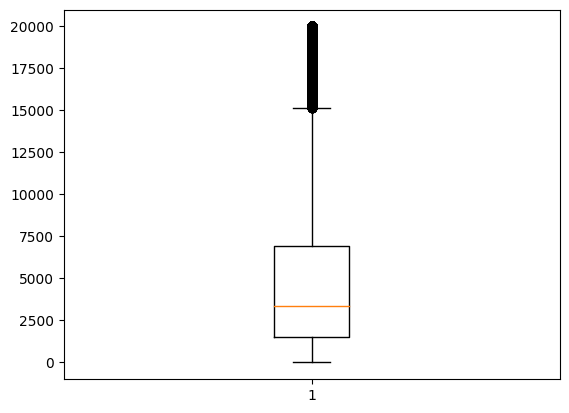

In [15]:
plt.boxplot(data['Price'])

In [16]:
data = data[data['Price'] >= 1000 ]

Так как цены на машины могут быть очень высокие, но никак не нулевые или копеечные, решил отсекать значения только с низшей границы.

### Пропущенные значения

In [17]:
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.025532
RegistrationYear     0.000000
Gearbox              0.012672
Power                0.000000
Model                0.029673
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.039212
Brand                0.000000
Repaired             0.118727
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

### Разделение данных на выборки

In [18]:
RANDOM_STATE = 78
TEST_SIZE = 0.25
train_data = data.drop(columns=['DateCrawled','Price','DateCreated','NumberOfPictures','LastSeen'])
test_data = data['Price']
X_test_1,X_train_1,y_test_1,y_train_1 = train_test_split(train_data,test_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### Обработка полученных значений в train

Доля пропусков в train:

In [19]:
X_train_1.isna().mean()

VehicleType          0.026041
RegistrationYear     0.000000
Gearbox              0.012740
Power                0.000000
Model                0.030114
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.040422
Brand                0.000000
Repaired             0.119937
PostalCode           0.000000
dtype: float64

In [20]:
X_train_1['Repaired'] = X_train_1['Repaired'].fillna('no')
X_train_1['Gearbox'] = X_train_1['Gearbox'].fillna('manual')
X_train_1['VehicleType'] = X_train_1['VehicleType'].fillna('other')

In [21]:
X_train_1 = X_train_1.dropna(subset=['Model','FuelType'])

In [22]:
y_train_1= y_train_1[X_train_1.index]


___Вывод по этапу:___ У загруженного датасета были удалены аномальные значения. Также после разделения были удалены пропуски в тренировочной выборке.

## Обучение моделей

### Модель линейной регресии.

In [25]:
ohe_columns_1 = [
    'VehicleType','Model','FuelType','Brand'
]
ord_columns_1 = ['Gearbox','Repaired']
num_columns_1 = ['RegistrationYear','Kilometer','RegistrationMonth','Power',]


In [26]:
X_train_1['Repaired'].value_counts()

no     42322
yes     2749
Name: Repaired, dtype: int64

In [27]:
ohe_pipe_1 = Pipeline(
    [('simpleImputer_ohe_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

In [28]:
ord_pipe_1 = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['manual','auto'],
                    ['no','yes'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [29]:
data_preprocessor_1 = ColumnTransformer(
    [('ohe', ohe_pipe_1, ohe_columns_1),
     ('num', MinMaxScaler(), num_columns_1),
     ('ord', ord_pipe_1, ord_columns_1)
    ], 
    remainder='passthrough'
)

In [30]:
pipe_final_1 = Pipeline([
    ('preprocessor', data_preprocessor_1),
    ('models', LinearRegression())
])

In [31]:
param_grid_1 = [
     {
     'models': [LinearRegression()],
     'models__fit_intercept': [True, False], 
     'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough']
    },
    {
        'models': [Ridge(), Lasso()],
        'models__alpha': [0.1, 1, 20],  
        'models__fit_intercept': [True, False], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough']
    }
 
]

In [32]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [34]:
randomized_search_1 = RandomizedSearchCV(
    pipe_final_1, 
    param_grid_1, 
    cv=10,
    scoring=make_scorer(rmse, greater_is_better=False),
    random_state=RANDOM_STATE,
)

In [35]:
X_train_1 = X_train_1[ohe_columns_1 + num_columns_1 + ord_columns_1]

In [36]:
%%time
randomized_search_1.fit(X_train_1, y_train_1)

D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115795253193.49979, tolerance: 217241730.272
  model = cd_fast.sparse_enet_coordinate_descent(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116591085085.25739, tolerance: 216656329.1523
  model = cd_fast.sparse_enet_coordinate_descent(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unkn

CPU times: total: 27.4 s
Wall time: 27.6 s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['VehicleType',
                                                                                'Model',
                                                                                'FuelType',
                                                                                'Brand']),
                                                                              ('num',
                                                                               MinMaxScaler(),
                                                                               ['Registra...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [Ridge(), Lasso()],
                                         'models__alpha': [0.1, 1, 20],
                                         'models__fit_intercept': [True, False],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=78,
                   scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

In [37]:
print('Лучшие пармметры модели:',randomized_search_1.best_params_)
print('Лучшие значение  метрики RMSE:',-randomized_search_1.best_score_)

Лучшие пармметры модели: {'preprocessor__num': RobustScaler(), 'models__fit_intercept': True, 'models__alpha': 1, 'models': Ridge()}
Лучшие значение  метрики RMSE: 2489.4993243084236


### Модель LightGBM 

In [38]:
RANDOM_STATE = 78
TEST_SIZE = 0.25
#train_data = data.drop(columns=['DateCrawled','Price','DateCreated'])
#test_data = data['Price']
X_test_2,X_train_2,y_test_2,y_train_2 = train_test_split(train_data,test_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)

Повторение обработки пропусков для выборок:

In [39]:
X_train_2['Repaired'] = X_train_2['Repaired'].fillna('no')
X_train_2['Gearbox'] = X_train_2['Gearbox'].fillna('manual')
X_train_2['VehicleType'] = X_train_2['VehicleType'].fillna('other')
X_train_2 = X_train_2.dropna(subset=['Model','FuelType'])

y_train_2= y_train_2[X_train_2.index]


In [40]:
ohe_pipe_2 = Pipeline(
    [('simpleImputer_ohe_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

In [41]:
ord_pipe_2 = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['manual','auto'],
                    ['no','yes'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [42]:
data_preprocessor_2 = ColumnTransformer(
    [('ohe', ohe_pipe_2, ohe_columns_1),
     ('num', MinMaxScaler(), num_columns_1),
     ('ord', ord_pipe_2, ord_columns_1)
    ], 
    remainder='passthrough'
)

In [43]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('model', LGBMRegressor())
])

In [44]:
param_grid_2 = {
    'model__num_leaves': [20, 30, 40],              # количество листьев дерева
    'model__learning_rate': [0.01, 0.05, 0.1],      # скорость обучения
    'model__n_estimators': [50, 100, 200]           # количество деревьев
}

In [45]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [46]:
grid_search = GridSearchCV(pipe_final_2, param_grid=param_grid_2, cv=3, scoring=rmse_scorer)

In [47]:
%%time
grid_search.fit(X_train_2, y_train_2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 204
[LightGBM] [Info] Start training from score 5828.846108


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 30047, number of used features: 206
[LightGBM] [Info] Start training from score 5801.682398


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 30048, number of used features: 206
[LightGBM] [Info] Start training from score 5800.626132


D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 45071, number of used features: 230
[LightGBM] [Info] Start training from score 5810.384771
CPU times: total: 2min 9s
Wall time: 21.7 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['VehicleType',
                                                                          'Model',
                                                                          'FuelType',
                                                                          'Brand']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['RegistrationYea...
                                                                                                         handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simpleImputer_after_ord',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['Gearbox',
                                                                          'Repaired'])])),
                                       ('model', LGBMRegressor())]),
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__n_estimators': [50, 100, 200],
                         'model__num_leaves': [20, 30, 40]},
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

In [48]:
print("Наилучшие параметры:", grid_search.best_params_)
print("Наилучшая оценка качества (по RMSE):", -grid_search.best_score_)

Наилучшие параметры: {'model__learning_rate': 0.1, 'model__n_estimators': 200, 'model__num_leaves': 40}
Наилучшая оценка качества (по RMSE): 1608.3711809098013


## Анализ моделей

### Анализ качества и времени работы моделей.

#### Качество моделей

In [49]:
print('Лучшие значение  метрики RMSE модели линейной регресии:',-randomized_search_1.best_score_)
print('Лучшие значение  метрики RMSE модели LightGBM:', -grid_search.best_score_)

Лучшие значение  метрики RMSE модели линейной регресии: 2489.4993243084236
Лучшие значение  метрики RMSE модели LightGBM: 1608.3711809098013


#### Время обучения моделей

Время обучения модели линейной регресии : 54 сек\
Время обучения модели LigthGBM : 2 мин.30 сек

#### Время предсказания моделей

In [50]:
%%time
y_pred_1 = randomized_search_1.predict(X_train_1)

CPU times: total: 62.5 ms
Wall time: 73.4 ms


In [51]:
%%time
y_pred_2 = grid_search.predict(X_train_2)

CPU times: total: 734 ms
Wall time: 195 ms


___Вывод по времени работы:___ Модель линейной регресии на порядок быстрее обучается и выдаёт предсказание.

___Вывод по качеству работы:___ Метрика RMSE гораздо лучше у второй модели (LightGBM)

#### Проверка модели LightGBM на тестовой выборке 

In [52]:
y_pred_2_test = grid_search.predict(X_test_2)
rmse = np.sqrt(mean_squared_error(y_test_2, y_pred_2_test))
print("RMSE модели LightGBM на тестовой выборке:", rmse)

D:\Anaconda\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RMSE модели LightGBM на тестовой выборке: 1654.007919260182


## Резюме и общий вывод

На предложенном датасете предварительно была проведена работа по подготовке данных.
Были изменены типы данных, заполнены пропуски и удалены аномальные значения.Далее были реализованы модели линейной регресии и Light GBM. Обе модели оценивались по метрике RMSE. Качественно Light GBM работает гораздо лучше и удовлетворяет ТЗ с большим запасом. Линейная регрессия работает во много раз быстрее но не дотягивает до требуемого порога качетсва. Так как в списке критериева заказчика качество стоит на первом месте,  я считаю что нужно использовать модель  Light GBM.